In [1]:
import edge_sensor
from edge_sensor.api.radio import SawtoothSource, NoiseSource, SingleToneSource
from edge_sensor.api.radio import base
from matplotlib import pyplot as plt
import labbench as lb
from scipy import signal
import numpy as np

lb.show_messages('info')

noise1 = NoiseSource()
noise1.open()

noise2 = NoiseSource()
noise2.open()
capture_dir = edge_sensor.RadioCapture(host_resample=False, duration=0.5)
capture_resamp = edge_sensor.RadioCapture(host_resample=True, duration=0.5)
capture_shift = edge_sensor.RadioCapture(
    host_resample=True, lo_shift='left', analysis_bandwidth=10e6, duration=0.5
)

base.design_capture_filter(noise1.base_clock_rate, capture_resamp)

(15625000.0,
 0,
 {'window': 'hamming',
  'nfft': 18750,
  'nfft_out': 18432,
  'frequency_shift': False,
  'passband': (None, None),
  'fs': 15625000.0})

In [2]:
iq, _ = noise1.acquire(capture_resamp, correction=True)
iq2, _ = noise2.acquire(capture_dir)
# sdr.stream.stop()
print(iq.shape)
# plt.plot(iq.real)
# plt.plot(np.roll(iq2.real))

(1, 7680000)


[0]
[0]


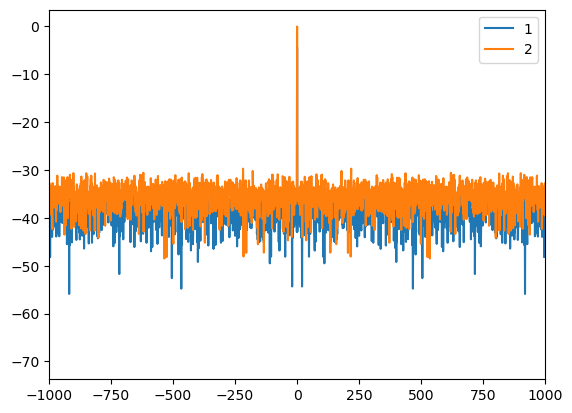

In [3]:
from scipy import signal
import iqwaveform

for name, x in {'1': iq, '2': iq2}.items():
    # R = signal.correlate(iq3, np.roll(iq, 34233))
    R = signal.correlate(x, x, mode='same')
    offs = np.arange(R.shape[-1]) - R.shape[-1] // 2
    R /= R.size
    plt.plot(offs, iqwaveform.powtodB(np.abs(R.T)), label=name)
    plt.xlim([-10e2, 10e2])

    peaks = offs[np.abs(R[0]) > 0.1]
    print(peaks)
    np.diff(peaks)
plt.legend()

[]


array([], dtype=int64)

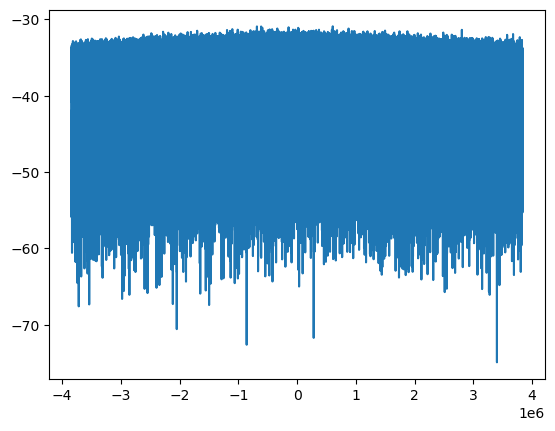

In [4]:
R = signal.correlate(iq, iq2, mode='same')
offs = np.arange(R.size) - R.size // 2
R /= R.size
plt.plot(offs, iqwaveform.powtodB(np.abs(R.T)))
# plt.xlim([-10e2, 10e2])

peaks = offs[np.abs(R[0]) > 0.1]
print(peaks)
np.diff(peaks)

### Single-tone source

In [5]:
fc = 3e6
cw_gen = SingleToneSource(resource=fc, noise_snr=30)
cw_gen.open()

cw_gen.arm(capture_resamp)
iq1, _ = cw_gen.acquire(capture_resamp)

cw_gen.arm(capture_dir)
iq2, _ = cw_gen.acquire(capture_dir)

cw_gen.arm(capture_dir)
iq3, _ = cw_gen.acquire(capture_shift)

# sdr.stream.stop()
# plt.plot(iq.real)
# plt.plot(np.roll(iq2.real))

output shape was  [[[-64.35287  -64.50597  -64.600334 ... -64.410774 -64.4283   -64.3785  ]]]
-4.815 MHz 6.4069757
output shape was  [[[-60.125183 -60.127922 -60.122036 ... -60.035572 -60.04303  -60.053123]]]
-4.68 MHz 10.846653
output shape was  [[[-89.88954  -89.88506  -89.88028  ... -89.90189  -89.898026 -89.893936]]]
-0.375 MHz -64.30984


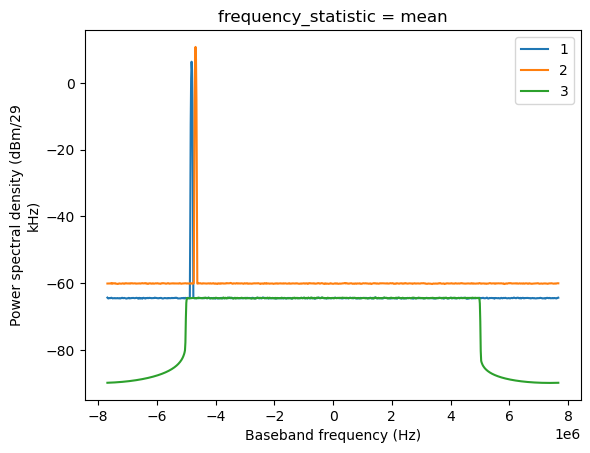

In [6]:
import channel_analysis

for name, iq in {'1': iq1, '2': iq2, '3': iq3}.items():
    result = channel_analysis.measurements.power_spectral_density(
        iq,
        capture_dir,
        window=('dpss', 3.5),
        frequency_resolution=15e3,
        frequency_statistic=('mean',),
    )
    print(result.idxmax('baseband_frequency').values[0]/1e6, 'MHz', result.max().values)

    # result = result - result.max()
    result.plot(label=name)
plt.legend()
# plt.ylim([-110,-100])

4.968000054359436e-07 MHz 11.936295
2.824999988079071e-07 MHz 13.647455
4.751000106334686e-07 MHz -32.71371


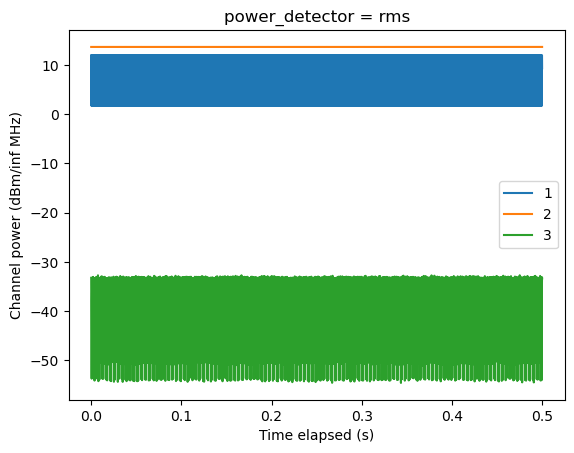

In [7]:
import channel_analysis

for name, iq in {'1': iq1, '2': iq2, '3': iq3}.items():
    result = channel_analysis.measurements.channel_power_time_series(
        iq,
        capture_dir,
        detector_period=1e-4,
        power_detectors=('rms',)
    )
    print(result.idxmax('time_elapsed').values[0]/1e6, 'MHz', result.max().values)

    # result = result - result.max()
    result.plot(label=name)

plt.legend()
# plt.ylim([-110,-100])

In [8]:
for capture in (capture_resamp, capture_dir, capture_shift):
    _, _, d = edge_sensor.api.radio.base.design_capture_filter(cw_gen.base_clock_rate, capture)
    print(20*np.log10(d['nfft']/d['nfft_out']))

0.14857620641239333
0.0
4.230975859530889
